# Annotation and Genothology in DNA Methylation Analysis

In DNA methylation analysis, annotation and genothology tools are critical for interpreting methylation patterns and their biological significance. The following tools are widely used in the analysis:

1. **[Annotatr](https://bioconductor.org/packages/release/bioc/vignettes/annotatr/inst/doc/annotatr-vignette.html) - Annotation**  

2. **[MissMethyl](https://bioconductor.org/packages/release/bioc/vignettes/missMethyl/inst/doc/missMethyl.html) - Gene ontology analysis**

## 0. Setup environment

In [2]:
from google.colab import drive
drive.mount('/content/drive',force_remount = True)

Mounted at /content/drive


In [3]:
# Run rmagic by executing this command
%load_ext rpy2.ipython

In [4]:
%%R

# setup workdir
folder = "/content/drive/MyDrive/DNAmethylation/"
output = paste0(folder,"/result")

In [5]:
%%R

# Install necessary packages from CRAN
install.packages("limma")  # For linear models in genomic data analysis
install.packages("qs")     # For fast serialization of R objects

# Install missMethyl from Bioconductor
if (!requireNamespace("BiocManager", quietly = TRUE)) {
  install.packages("BiocManager")
}
BiocManager::install("missMethyl")

# Install IlluminaHumanMethylationEPICanno.ilm10b4.hg19 from Bioconductor
BiocManager::install("IlluminaHumanMethylationEPICanno.ilm10b4.hg19")


Update all/some/none? [a/s/n]: n
Update all/some/none? [a/s/n]: n


Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)
Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)
also installing the dependencies ‘RcppParallel’, ‘RApiSerialize’, ‘stringfish’, ‘BH’

trying URL 'https://cran.rstudio.com/src/contrib/RcppParallel_5.1.10.tar.gz'
Content type 'application/x-gzip' length 1633793 bytes (1.6 MB)
downloaded 1.6 MB

trying URL 'https://cran.rstudio.com/src/contrib/RApiSerialize_0.1.4.tar.gz'
Content type 'application/x-gzip' length 9485 bytes
downloaded 9485 bytes

trying URL 'https://cran.rstudio.com/src/contrib/stringfish_0.16.0.tar.gz'
Content type 'application/x-gzip' length 1153517 bytes (1.1 MB)
downloaded 1.1 MB

trying URL 'https://cran.rstudio.com/src/contrib/BH_1.87.0-1.tar.gz'
Content type 'application/x-gzip' length 14335542 bytes (13.7 MB)
downloaded 13.7 MB

trying URL 'https://cran.rstudio.com/src/contrib/qs_0.27.3.tar.gz'
Content type 'application/x-gzip' length 2154523 bytes (2.

## Gene ontology analysis
Once a differential methylation or differential variability analysis has been performed, it may be of interest to know which gene pathways are targeted by the significant CpG sites.

In [6]:
%%R

# loading library
library(missMethyl)
library(IlluminaHumanMethylationEPICanno.ilm10b4.hg19)
library(limma)
library(qs)
library(ggplot2)

Loading required package: IlluminaHumanMethylation450kanno.ilmn12.hg19
Loading required package: minfi
Loading required package: BiocGenerics

Attaching package: ‘BiocGenerics’

The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs

The following objects are masked from ‘package:base’:

    anyDuplicated, aperm, append, as.data.frame, basename, cbind,
    colnames, dirname, do.call, duplicated, eval, evalq, Filter, Find,
    get, grep, grepl, intersect, is.unsorted, lapply, Map, mapply,
    match, mget, order, paste, pmax, pmax.int, pmin, pmin.int,
    Position, rank, rbind, Reduce, rownames, sapply, saveRDS, setdiff,
    table, tapply, union, unique, unsplit, which.max, which.min

Loading required package: GenomicRanges
Loading required package: stats4
Loading required package: S4Vectors

Attaching package: ‘S4Vectors’

The following object is masked from ‘package:utils’:

    findMatches

The following objects are masked from ‘package:base’:

    expand

All input CpGs are used for testing.


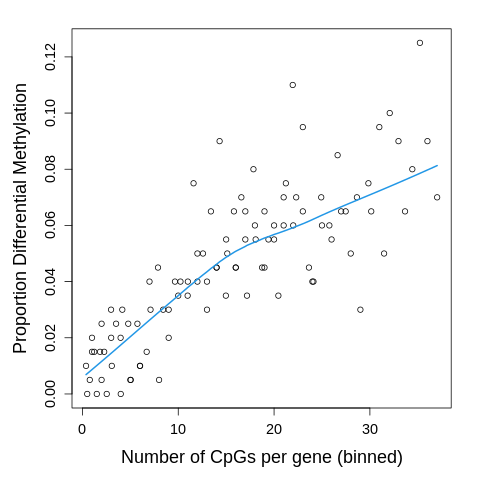

In [7]:
%%R

# loading DMR
DMR <- qread(paste0(folder,"data/DMRrange.hg19.RDS"))

# create annot
ann <- getAnnotation(IlluminaHumanMethylationEPICanno.ilm10b4.hg19)

# All CpG sites tested
allcpgs <- rownames(ann)

# genonthology
gst.region <- goregion(DMR, all.cpg = allcpgs, collection = "GO", array.type = "EPIC", plot.bias = TRUE)

In [8]:
%%R

# collect all pathways
GO_all <- as.data.frame(gst.region)
write.table(GO_all, paste0(output, "/pathways_GO.tsv"), col.names = T, row.names = F, sep = "\t", quote = F)

## Visulaization

In [9]:
%%R

# loading data Go
GO <- read.delim(paste0(output,"/pathways_GO.tsv"), sep = "\t")

In [10]:
%%R

# Collect pathways have FDR smaller than 0.05
GO <- GO[GO$FDR <= 0.05, ]
GO <- GO[order(GO$P.DE), ]
GO$log10 <- -log10(GO$FDR)
GO$rich_ratio <- GO$DE / GO$N

In [11]:
%%R
# Caculated log10 and rich_ratio
GO$log10 <- -log10(GO$FDR)
GO$rich_ratio <- GO$DE / GO$N

# order the rich_ratio
GO$TERM <- with(GO, reorder(TERM, rich_ratio, na.rm = T))

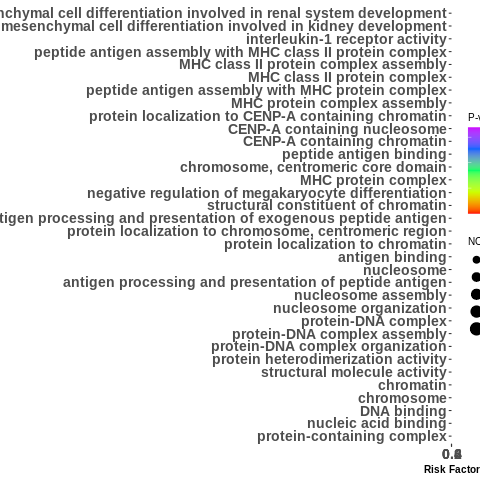

In [15]:
%%R

# visulaization
ggplot(GO, aes(x = rich_ratio, y = TERM)) +
    geom_segment(aes(yend = TERM), xend = 0, colour = "grey50") +
    geom_point(aes(colour = P.DE, size =N)) +
    scale_color_gradientn(colours = rainbow(5)) +
    theme_bw() +
    labs(x = "Risk Factor", y = NULL, color = "P-value", size = "NO. Gene") +
    theme(
        text = element_text(size = 10),
        axis.title = element_text(face = "bold"),
        axis.text = element_text(face = "bold", size = 14)
    )


In [16]:
%%R
ggsave(paste0(output, "/pathway_plot.pdf"), width = 15, height = 10)

In [17]:
%%R
ggsave(paste0(output, "/pathway_plot.png"), width = 15, height = 10)

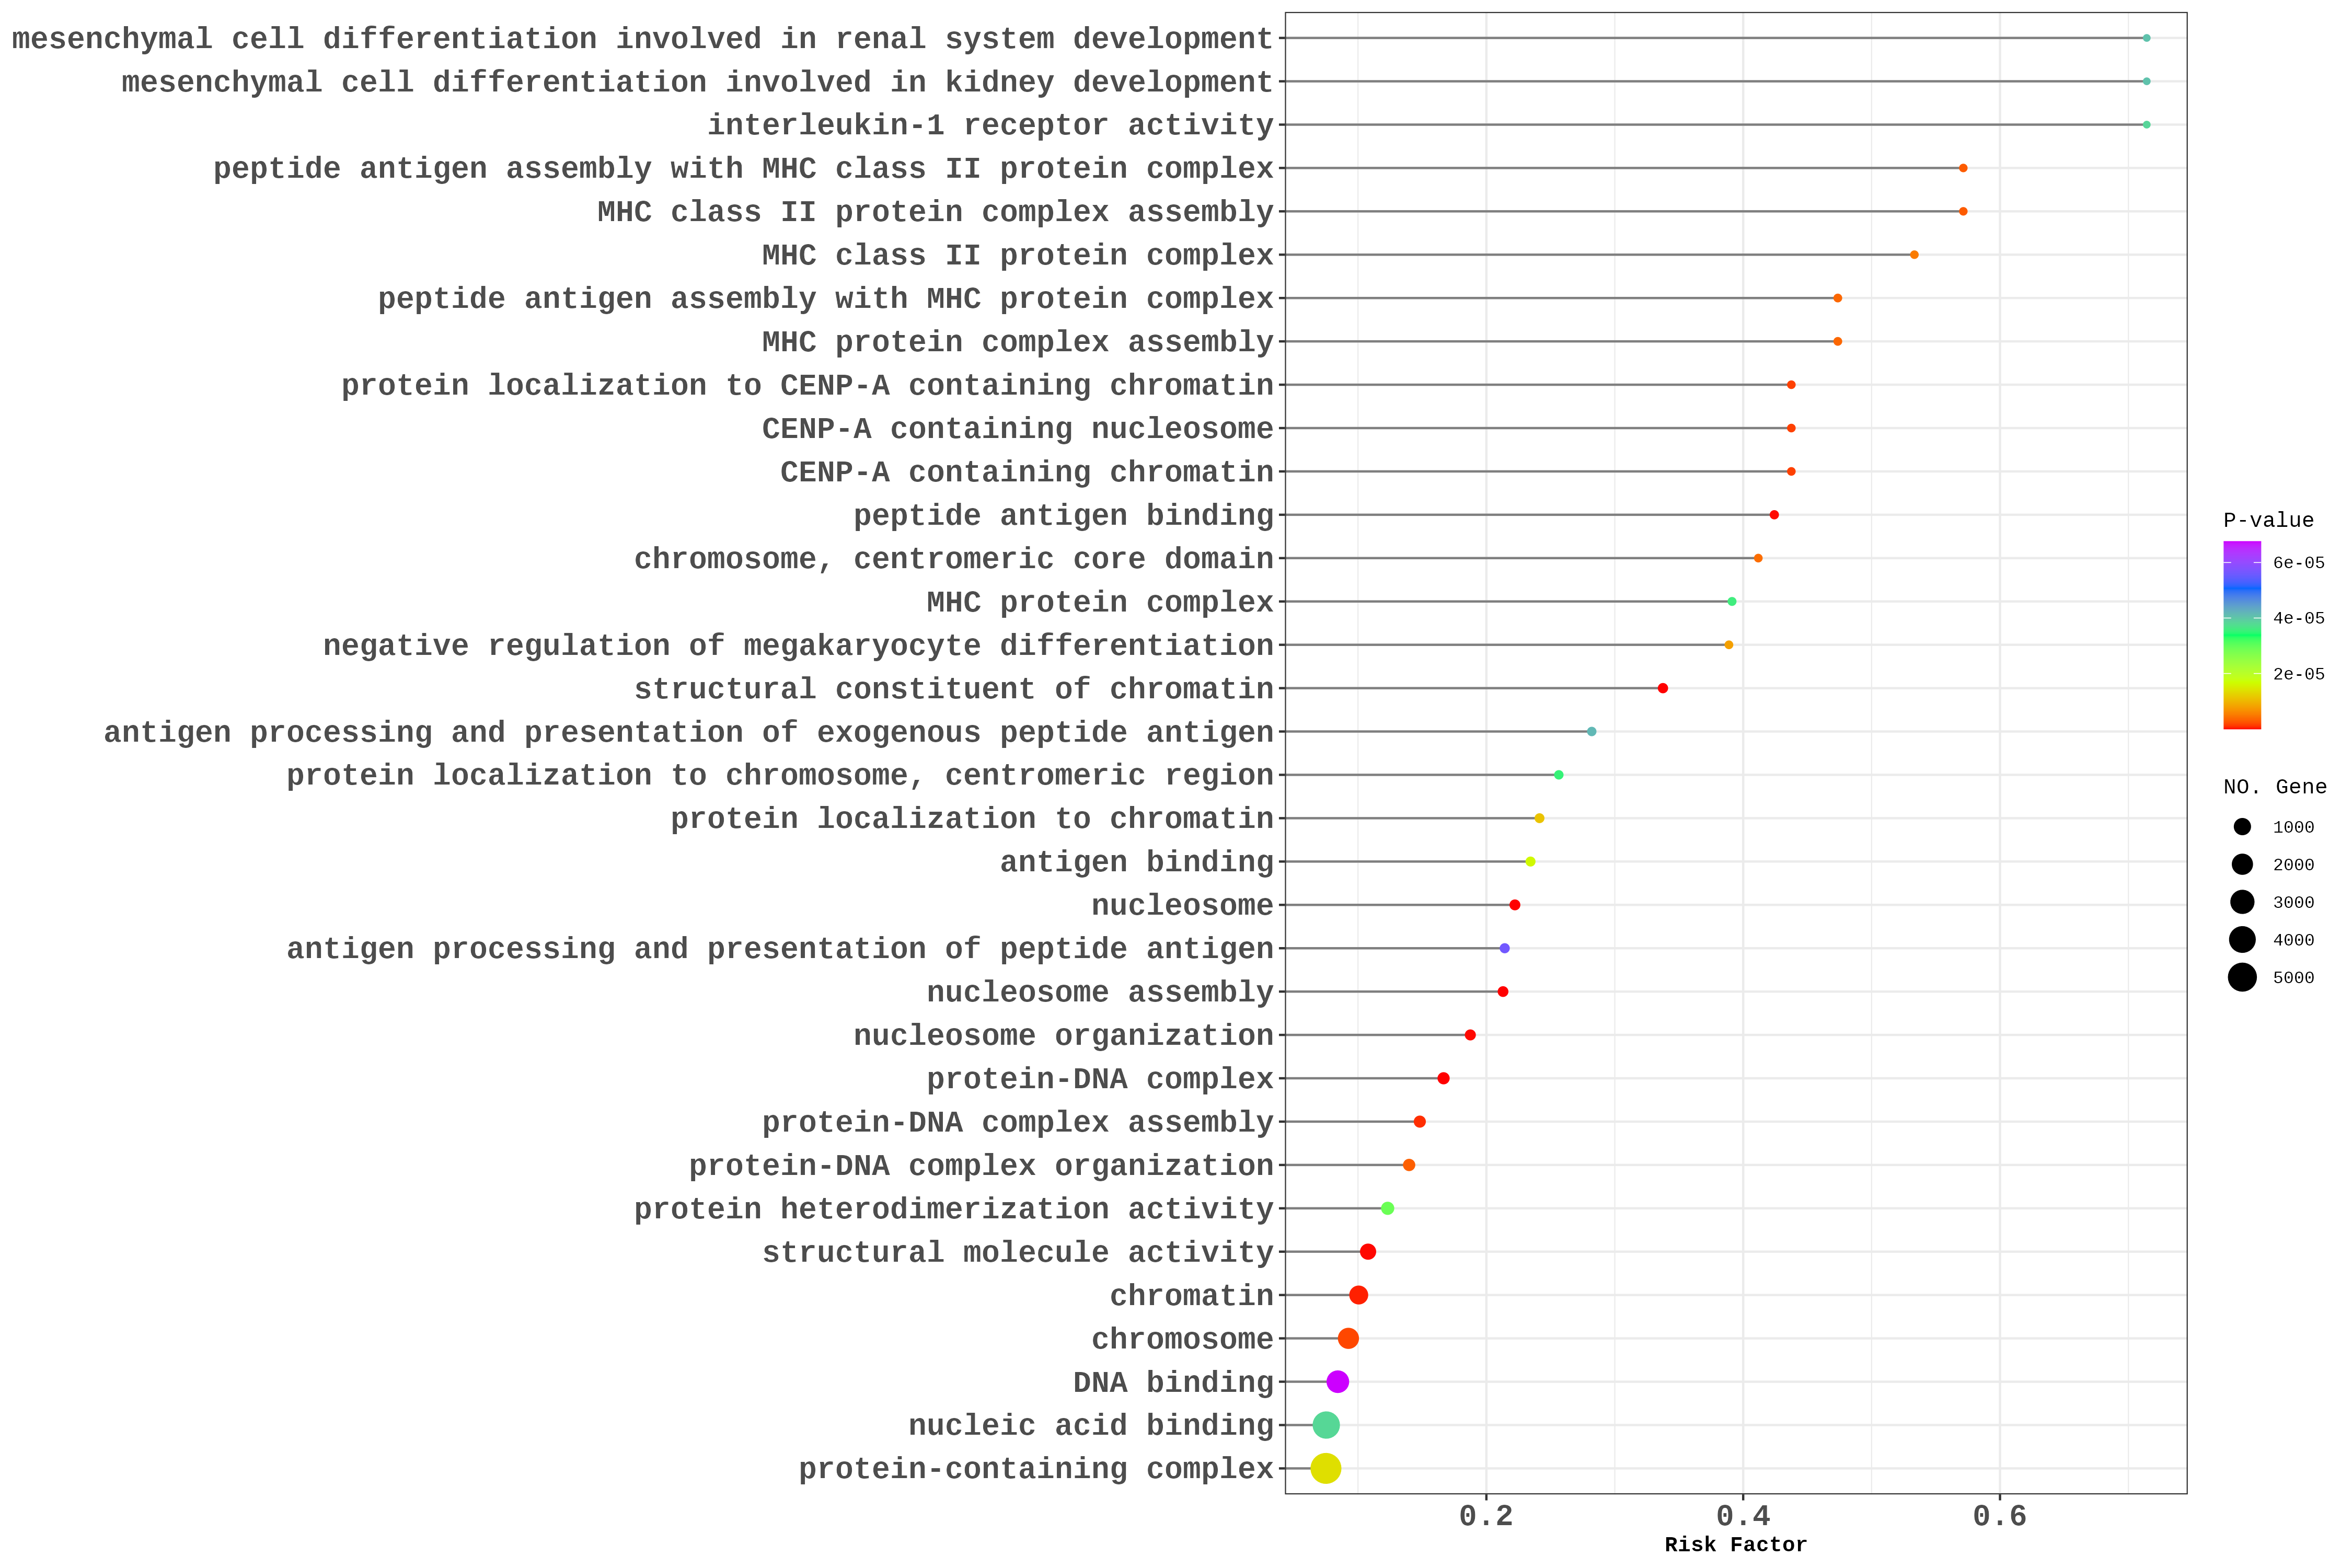plot